In [1]:
!python3 --version

Python 3.10.14


In [2]:
!pip install pyqubo openjij

In [7]:
!which pip

/Users/aaaaa/.pyenv/versions/3.10.14/bin/pip


In [39]:
from pyqubo import Array, Placeholder, solve_ising, Constraint, SubH, Model, Binary
import re, random, math
import numpy as np
import openjij as oj
import time 

In [40]:
# resourceに番号を割り当てる
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [41]:
# resource_m = {'R0':['m11','m12'],'R1':['m21','m22','m23'],'R2':['m31','m32','m33','m34','m35','m36']}
# resource_t = {'R0':['t11','t21','t31','t41'],'R1':['t12','t22','t32','t42'],
#               'R2':['t13','t23','t33','t43']}

# place = [['p11','p12','p13','p14'],['p21','p22','p23','p24'],['p31','p32','p33','p34'],['p41','p42','p43','p44']]

# job = [['t11','t12','t13'],['t21','t22','t23'],['t31','t32','t33'],['t41','t42','t43']]

# machine_processing_time = {'m11':1,'m12':2,'m21':3,'m22':1,'m23':2,'m31':1,'m32':3,'m33':2,
#                           'm34':2,'m35':1,'m36':2}

# machine_cost = {'m11':10,'m12':14,'m21':13,'m22':10,'m23':10,'m31':12,'m32':10,'m33':9,
#                           'm34':12,'m35':14,'m36':15}

# import random

# # Machine keys
# machine_keys = ['m11', 'm12', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33', 'm34', 'm35', 'm36']

# # Generate random processing times and costs
# machine_processing_time = {key: random.randint(1, 3) for key in machine_keys}  
# machine_cost = {key: random.randint(9, 15) for key in machine_keys}  

# print("Machine Processing Time:", machine_processing_time)
# print("Machine Cost:", machine_cost)

# resource_num = assign_resource_num(resource_m)

# resource_num

In [42]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs, seed=None):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []
    job_tasks = {}  # タスク長を格納する辞書

    # シードを設定（指定された場合のみ）
    if seed is not None:
        random.seed(seed)

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

        # 各タスクに1から10の範囲でランダムなタスク長を割り当てる
        job_tasks[t11] = random.randint(1, 10)  # t11にランダムなタスク長を割り当て
        job_tasks[t12] = random.randint(1, 10)  # t12にランダムなタスク長を割り当て
        job_tasks[t13] = random.randint(1, 10)  # t13にランダムなタスク長を割り当て

    return resource_t, place, job, job_tasks

In [43]:
resource_m = {'R0': ['m11', 'm12'], 'R1': ['m21', 'm22'], 'R2': ['m31', 'm32']}
machine_processing_time = {'m11': 1, 'm12': 2, 'm21': 3, 'm22': 1, 'm31': 1, 'm32': 3}
machine_cost = {'m11': 10, 'm12': 14, 'm21': 13, 'm22': 10, 'm31': 12, 'm32': 10}

resource_num = assign_resource_num(resource_m)

resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [44]:
# ジョブ数を指定して生成
num_jobs = 15
resource_t, place, job, job_tasks = generate_jobs_and_resources(num_jobs, seed=42)

In [45]:
# job_tasks = {'t11': 2, 't12': 1,'t13': 5,'t21': 4,'t22': 4,'t23': 3, 't31': 2,'t32': 9,'t33': 2,'t41': 10,'t42': 7,
#              't43': 1,'t51': 1,'t52': 2,'t53': 4,'t61': 4,'t62': 9,'t63': 10,'t71': 1,'t72': 9,'t73': 4,'t81': 9,
#              't82': 7,'t83': 4,'t91': 8,'t92': 10,'t93': 5,'t101': 1,'t102': 3, 't103': 7,'t111': 6,'t112': 5,
#              't113': 3,'t121': 4,'t122': 6,'t123': 2,'t131': 2,'t132': 7,'t133': 2,'t141': 6,'t142': 6,'t143': 10,'t151': 5,
#              't152': 1,'t153': 8}

In [46]:
# トランジションに番号を割り当てる
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14,
 't61': 15,
 't62': 16,
 't63': 17,
 't71': 18,
 't72': 19,
 't73': 20,
 't81': 21,
 't82': 22,
 't83': 23,
 't91': 24,
 't92': 25,
 't93': 26,
 't101': 27,
 't102': 28,
 't103': 29,
 't111': 30,
 't112': 31,
 't113': 32,
 't121': 33,
 't122': 34,
 't123': 35,
 't131': 36,
 't132': 37,
 't133': 38,
 't141': 39,
 't142': 40,
 't143': 41,
 't151': 42,
 't152': 43,
 't153': 44}

In [47]:
t_num = len(transition_num)
r_num = len(resource_num)
limit_time = 30 #制限の最大時間
x = Array.create('x', (limit_time,t_num,r_num), 'BINARY') # binaryの宣言

In [48]:
# # タスク長を一定にしたいときに使うかも
# def update_job_tasks(key, value):
#     global job_tasks
#     if key in job_tasks:
#         print(f"既存のタスク {key} を更新: {job_tasks[key]} -> {value}")
#     else:
#         print(f"新しいタスク {key} を追加: {value}")
#     job_tasks[key] = value

# # 実行例
# update_job_tasks("t11", 3)  # t11 を 3 に更新
# job_tasks = {'t11': 2, 't12': 1,'t13': 5,'t21': 4,'t22': 4,'t23': 3, 't31': 2,'t32': 9,'t33': 2,'t41': 10,'t42': 7,
#              't43': 1,'t51': 1,'t52': 2,'t53': 4,'t61': 4,'t62': 9,'t63': 10,'t71': 1,'t72': 9,'t73': 4,'t81': 9,
#              't82': 7,'t83': 4,'t91': 8,'t92': 10,'t93': 5,'t101': 1,'t102': 3, 't103': 7,'t111': 6,'t112': 5,
#              't113': 3,'t121': 4,'t122': 6,'t123': 2,'t131': 2,'t132': 7,'t133': 2,'t141': 6,'t142': 6,'t143': 10,'t151': 5,
#              't152': 1,'t153': 8}

## Binary変数
x(時間,トランジション,マシーン)

In [49]:
def cal_min_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最小を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最小時間を求める
    """
    min_m_time = []
    for idx,v in enumerate(resource_m):
        _min = 10000
        for i in resource_m[v]:
            _min = min(_min,machine_processing_time[i])
        min_m_time.append(_min)
    return min_m_time

In [50]:
def cal_max_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最大を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最大時間を求める
    """
    max_m_time = []
    for idx,v in enumerate(resource_m):
        _min = -1
        for i in resource_m[v]:
            _min = max(_min,machine_processing_time[i])
        max_m_time.append(_min)
    return max_m_time

In [51]:
def calc_upper_limit(step, jobs, limit_time, _max):
    """
    現在のステップにおける処理時間の上限時間の計算
    Args:
        step : 現在のステップ
        jobs : 各jobのタスクのリスト
        limit_time : 制限時間
        _max : 各リソースマシーンのprocessing timeの最大値のリスト(max_list)

    Returns:
    現在のステップの上限時間を求める
    """
    p_time = 0
    for job in jobs: #jobはstr型
        if len(job) >= 4:
            if int(job[3]) >= step:
                p_time += _max[int(job[3])-1]
        elif int(job[2]) >= step:
                p_time += _max[int(job[2])-1]
    return limit_time - p_time

In [52]:
# 各トランジションの処理時間の最大・最小値を求める
range_trantision_ptime = {}
min_list = cal_min_processing(resource_m, machine_processing_time)
max_list = cal_max_processing(resource_m, machine_processing_time)

#各タスクの下限と上限時間
#'t11': [0, 22] t11は最低0秒、最高22秒で開始しなければならない
for idx, j in enumerate(job):
    for i in range(len(j)):
        range_time = []
        lb = sum(min_list[0:i]) if i != 0 else 0
        range_time.append(lb)
        ub = calc_upper_limit(i+1, j, limit_time, max_list)
        range_time.append(ub)
        range_trantision_ptime[j[i]] = range_time
range_trantision_ptime

{'t11': [0, 22],
 't12': [1, 24],
 't13': [2, 27],
 't21': [0, 22],
 't22': [1, 24],
 't23': [2, 27],
 't31': [0, 22],
 't32': [1, 24],
 't33': [2, 27],
 't41': [0, 22],
 't42': [1, 24],
 't43': [2, 27],
 't51': [0, 22],
 't52': [1, 24],
 't53': [2, 27],
 't61': [0, 22],
 't62': [1, 24],
 't63': [2, 27],
 't71': [0, 22],
 't72': [1, 24],
 't73': [2, 27],
 't81': [0, 22],
 't82': [1, 24],
 't83': [2, 27],
 't91': [0, 22],
 't92': [1, 24],
 't93': [2, 27],
 't101': [0, 22],
 't102': [1, 24],
 't103': [2, 27],
 't111': [0, 22],
 't112': [1, 24],
 't113': [2, 27],
 't121': [0, 22],
 't122': [1, 24],
 't123': [2, 27],
 't131': [0, 22],
 't132': [1, 24],
 't133': [2, 27],
 't141': [0, 22],
 't142': [1, 24],
 't143': [2, 27],
 't151': [0, 22],
 't152': [1, 24],
 't153': [2, 27]}

## H_firing

In [53]:
#制約
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):
        sigma_h_firing = 0.0
        for r in resource_m['R'+str(i)]:
            lb = range_trantision_ptime[j[i]][0]
            ub = range_trantision_ptime[j[i]][1]
            for k in range(lb,ub):
                t = transition_num['t'+str(idx+1)+str(i+1)]
                sigma_h_firing += x[k,t,resource_num[r]]
        H_firing += Constraint((1-sigma_h_firing)**2,label="one_fired_t{}{}{}".format(idx+1,i+1,resource_num[r]))

## H_conflict

In [54]:
#制約
H_conflict = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        for j1 in range(len(job)):
            t1 = transition_num[job[j1][i]]
            for j2 in range(len(job)):
                t2 = transition_num[job[j2][i]]
                if j1 != j2:
                    lb = range_trantision_ptime[job[j1][i]][0]
                    ub = range_trantision_ptime[job[j1][i]][1]
                    
                    # j1 のタスク処理時間を計算
                    task_length = job_tasks[job[j1][i]]
                    processing_time = math.ceil(task_length / machine_processing_time[r])
                    
                    for k1 in range(lb,limit_time+1):
                        fd = k1 + processing_time

                        for k2 in range(k1,min(fd,limit_time)):
                            H_conflict += Constraint((x[k1,t1,resource_num[r]])*(x[k2,t2,resource_num[r]]), label="conflict{}".format(t1))


## H_precedence

In [55]:
#制約
H_precedence = 0.0

for idx, j in enumerate(job):
    for i in range(len(j)):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        for r1 in resource_m['R'+str(i)]:
            if i+1 < len(j):
                for r2 in resource_m['R'+str((i+1))]:
                    t1 = transition_num['t'+str(idx+1)+str(i+1)]
                    t2 = transition_num['t'+str(idx+1)+str(i+2)]
                    
                    task_length = job_tasks['t'+str(idx+1)+str(i+1)] # 現在のタスクの長さ
                    processing_time = math.ceil(task_length / machine_processing_time[r1])
                            
                    for k1 in range(0, limit_time):
                        fd = k1 + processing_time

                        for k2 in range(min(fd, limit_time)):
                            H_precedence += Constraint((x[k1,t1,resource_num[r1]])*(x[k2,t2,resource_num[r2]]), 
                                                       label="precedence{}{}{}{}".format(k1,t1,k2,t2))


## H_resourceCost

In [56]:
#目的関数
H_resourceCost = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        r_num = resource_num[r]
        rc = machine_cost[r]
        fd = machine_processing_time[r]
        for j in range(len(job)):
            lb = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
            ub = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
            t = transition_num['t'+str(j+1)+str(i+1)]
            for k in range(lb,ub):
                H_resourceCost += rc*fd*x[k,t,r_num]

## H_waitingTime

In [57]:
#目的関数
H_waitingTime = 0.0

for j in range(len(job)):
    for i in range(len(job[j])-1):
        #後のタスク
        lb1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][0]
        ub1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][1]
        t1 = transition_num['t'+str(j+1)+str(i+2)]
        #前のタスク
        lb2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
        ub2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
        t2 = transition_num['t'+str(j+1)+str(i+1)]
        for k1 in range(lb1,ub1):
            for r1 in resource_m['R'+str(i+1)]:
                r_num1 = resource_num[r1]
                for k2 in range(lb2,ub2):
                    for r2 in resource_m['R'+str(i)]:
                        fd = k2 + machine_processing_time[r2]
                        r_num2 = resource_num[r2]
                        if k1 - fd >= 0:
                            H_waitingTime += (k1 - fd) * x[k2,t2,r_num2] * x[k1,t1,r_num1]
                            

## ベイズ最適化

In [58]:
# import pandas as pd
# import optuna
# import openjij as oj
# import re

# A = Placeholder("A")
# B = Placeholder("B")
# C = Placeholder("C")

# # 結果を保存するためのリスト
# results = []
# decoded_results = []  # sort_ans を保存するためのリスト

# def extractVariable(s):  
#     literal = re.split('[\[\]]', s)
#     while '' in literal:
#         literal.remove('')       
#     return literal

# def objective(trial):
#     # A = trial.suggest_float("A", 100, 1000)
#     # B = trial.suggest_float("B", 100, 1000)
#     # C = trial.suggest_float("C", 100, 1000)
#     D = trial.suggest_float("D", 1, 30)
#     E = trial.suggest_float("E", 1, 50)

#     H = (
#         A * SubH(H_firing, "SubH1") +
#         B * SubH(H_conflict, "SubH2") +
#         C * SubH(H_precedence, "SubH3") +
#         D * SubH(H_resourceCost, "SubH4") +
#         E * SubH(H_waitingTime, "SubH5")
#     )
#     model = H.compile()
#     # feed_dict = {"A": A, "B": B, "C": C, "D": D, "E": E}
#     feed_dict = {"A": 700, "B": 150, "C": 250, "D": D, "E": E}
#     bqm = model.to_bqm(feed_dict=feed_dict)
    
#     # アニーリング回数
#     num_iterations = 100

#     # QUBOを辞書形式に変換
#     qubo_dict = bqm.to_qubo()[0]

#     sampler = oj.SASampler()
#     response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

#     # サンプリング結果をデコード
#     decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

#     # 最良のサンプルを選択
#     best_sample = min(decoded_samples, key=lambda x: x.energy)

#     # サンプルから値が1の変数を抽出
#     keys = [k for k, v in best_sample.sample.items() if v == 1]
    
#     ans = []

#     for k in keys:
#         ans.append(extractVariable(k))

#     sort_ans = list(range(len(ans)))

#     for i in ans:
#         sort_ans[int(i[2])] = i

#     # sort_ans をリストに保存
#     decoded_results.append({
#         "trial": trial.number,
#         "energy": best_sample.energy,
#         "sort_ans": sort_ans  # ソートされたデコード結果
#     })

#     # 他の結果を保存
#     results.append({
#         "trial": trial.number,
#         "num_qubits": len(bqm.variables),
#         "energy": best_sample.energy,
#         "feasible": all(best_sample.subh.get(i, float('inf')) == 0 for i in ['SubH1', 'SubH2', 'SubH3']),
#         "SubH1": best_sample.subh.get('SubH1', None),
#         "SubH2": best_sample.subh.get('SubH2', None),
#         "SubH3": best_sample.subh.get('SubH3', None),
#         "SubH4": best_sample.subh.get('SubH4', None),
#         "SubH5": best_sample.subh.get('SubH5', None),
#         "D": D,
#         "E": E
#     })

#     # 最良サンプルのエネルギーを返す
#     return best_sample.subh.get('SubH4', float('inf')), best_sample.subh.get('SubH5', float('inf'))



In [59]:
import pandas as pd
import optuna
import openjij as oj
import re

# A = Placeholder("A")
# B = Placeholder("B")
# C = Placeholder("C")

# 結果を保存するためのリスト
results = []
decoded_results = []  # sort_ans を保存するためのリスト

def extractVariable(s):  
    literal = re.split('[\[\]]', s)
    while '' in literal:
        literal.remove('')       
    return literal

def objective(trial):
    A = trial.suggest_int("A", 400, 1000)
    B = trial.suggest_int("B", 100, 300)
    C = trial.suggest_int("C", 150, 400)
    D = trial.suggest_int("D", 1, 20)
    E = trial.suggest_int("E", 1, 50)
    
    # A = trial.suggest_float("A", 600, 800)
    # B = trial.suggest_float("B", 150, 300)
    # C = trial.suggest_float("C", 200, 400)
    # D = trial.suggest_float("D", 1, 30)
    # E = trial.suggest_float("E", 1, 50)

    H = (
        A * SubH(H_firing, "SubH1") +
        B * SubH(H_conflict, "SubH2") +
        C * SubH(H_precedence, "SubH3") +
        D * SubH(H_resourceCost, "SubH4") +
        E * SubH(H_waitingTime, "SubH5")
    )
    model = H.compile()
    feed_dict = {"A": A, "B": B, "C": C, "D": D, "E": E}
    # feed_dict = {"A": 600, "B": 150, "C": 250, "D": D, "E": E}
    bqm = model.to_bqm(feed_dict=feed_dict)
    
    # アニーリング回数
    num_iterations = 100

    # QUBOを辞書形式に変換
    qubo_dict = bqm.to_qubo()[0]

    sampler = oj.SASampler()
    response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

    # サンプリング結果をデコード
    decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

    # 最良のサンプルを選択
    best_sample = min(decoded_samples, key=lambda x: x.energy)

    # サンプルから値が1の変数を抽出
    keys = [k for k, v in best_sample.sample.items() if v == 1]
    
    ans = []

    for k in keys:
        ans.append(extractVariable(k))

    sort_ans = list(range(len(ans)))

    for i in ans:
        sort_ans[int(i[2])] = i

    # sort_ans をリストに保存
    decoded_results.append({
        "trial": trial.number,
        "energy": best_sample.energy,
        "sort_ans": sort_ans  # ソートされたデコード結果
    })

    # feasibleかどうかを確認
    feasible = all(best_sample.subh.get(i, float('inf')) == 0 for i in ['SubH1', 'SubH2', 'SubH3'])

    # 他の結果を保存
    results.append({
        "trial": trial.number,
        "num_qubits": len(bqm.variables),
        "energy": best_sample.energy,
        "feasible": feasible,
        "SubH1": best_sample.subh.get('SubH1', None),
        "SubH2": best_sample.subh.get('SubH2', None),
        "SubH3": best_sample.subh.get('SubH3', None),
        "SubH4": best_sample.subh.get('SubH4', None),
        "SubH5": best_sample.subh.get('SubH5', None),
        "A": A,
        "B": B,
        "C": C,
        "D": D,
        "E": E
    })

    # feasible でなければペナルティを返す
    if not feasible:
        return float('inf'), float('inf')  # 大きな値でペナルティ

    # feasible であれば SubH4 と SubH5 の値を返す
    return best_sample.subh.get('SubH4', float('inf')), best_sample.subh.get('SubH5', float('inf'))


In [ ]:

# Optuna の最適化を実行
# study = optuna.create_study(directions=('minimize', 'minimize'))
# study.optimize(objective, n_trials=30)
sampler = optuna.samplers.MOTPESampler(seed=1234)
study = optuna.create_study(directions=["minimize", "minimize"], sampler=sampler)
study.optimize(objective, n_trials=30)

# 結果をデータフレームに変換
df_results = pd.DataFrame(results)
df_decoded = pd.DataFrame(decoded_results)

# 結果をCSVファイルとして保存
df_results.to_csv("optimization_results.csv", index=False)
df_decoded.to_csv("decoded_results.csv", index=False)

[I 2025-01-24 17:27:41,792] A new study created in memory with name: no-name-22700b8b-a01b-4782-a1de-b7af58dcb496
[I 2025-01-24 17:28:17,629] Trial 0 finished with values: [inf, inf] and parameters: {'A': 625, 'B': 291, 'C': 333, 'D': 12, 'E': 8}. 
[I 2025-01-24 17:28:56,250] Trial 1 finished with values: [inf, inf] and parameters: {'A': 493, 'B': 111, 'C': 367, 'D': 13, 'E': 36}. 
[I 2025-01-24 17:29:37,871] Trial 2 finished with values: [inf, inf] and parameters: {'A': 412, 'B': 294, 'C': 358, 'D': 5, 'E': 10}. 
[I 2025-01-24 17:30:17,987] Trial 3 finished with values: [inf, inf] and parameters: {'A': 510, 'B': 161, 'C': 281, 'D': 9, 'E': 15}. 
[I 2025-01-24 17:31:02,468] Trial 4 finished with values: [inf, inf] and parameters: {'A': 767, 'B': 128, 'C': 223, 'D': 8, 'E': 23}. 
[I 2025-01-24 17:31:42,173] Trial 5 finished with values: [inf, inf] and parameters: {'A': 871, 'B': 140, 'C': 279, 'D': 12, 'E': 3}. 
[I 2025-01-24 17:32:23,139] Trial 6 finished with values: [inf, inf] and pa

## PyQUBOで定式化

In [78]:
# #ハミルトニアンを構築
# A = Placeholder("A")
# B = Placeholder("B")
# C = Placeholder("C")
# D = Placeholder("D")
# E = Placeholder("E")

# H = A * SubH(H_firing, "SubH1") + B * SubH(H_conflict, "SubH2") + C * SubH(H_precedence, "SubH3") + D * SubH(H_resourceCost, "SubH4") + E * SubH(H_waitingTime, "SubH4")

In [79]:
# # モデルをコンパイル
# model = H.compile()

In [80]:
# #PyQUBOの場合
# feed_dict = {"A": 600.0, "B": 150.0, "C": 250.0, "D": 8.189090682003714, "E": 2.206725381181465}


In [81]:
# # QUBOを作成
# bqm = model.to_bqm(feed_dict=feed_dict)

In [82]:
# # QUBOの変数数（量子ビットの数）を確認
# num_qubits = len(bqm.variables)
# print(f"Number of qubits: {num_qubits}")

## OpenJijで計算

In [83]:
# import openjij as oj
# import jijmodeling_transpiler as jmt

In [84]:
# # アニーリング回数
# num_iterations = 100

# # QUBOを辞書形式に変換
# qubo_dict = bqm.to_qubo()[0]

# # OpenJijのSamplerを使用してQUBOを解く
# sampler = oj.SASampler()

# response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

# # サンプリング結果をデコード
# decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)
# # sampleset = jmt.core.pubo.decode_from_openjij(response, pubo_builder, compiled_model)

# # 最良のサンプルを選択
# best_sample = min(decoded_samples, key=lambda x: x.energy)
# num_broken = len(best_sample.constraints(only_broken=True))

In [85]:
# # 最良のサンプルの各サブハミルトニアンの値を計算する関数
# # 上手く計算できてると思われるが使わないでもいい
# def calculate_subh_energy(subh, sample, feed_dict):
#     """
#     各サブハミルトニアンの計算
#     Args:
#         subh: サブハミルトニアン
#         sample: 最良のサンプル
#         feed_dict: ハイパーパラメータ
#     Returns:
#         ハミルトニアンの各項のエネルギーを計算する
#     """
#     subh_model = subh.compile()
#     subh_qubo, subh_offset = subh_model.to_qubo(feed_dict=feed_dict)
#     subh_energy = sum(subh_qubo.get((v, v), 0) * sample[v] for v in sample) #一次項の計算
#     for (v1, v2), coeff in subh_qubo.items(): #二次の項の計算
#         if v1 != v2:
#             subh_energy += coeff * sample[v1] * sample[v2]
#     return subh_energy + subh_offset

In [86]:
# #目的関数のエネルギー
# resource_cost = calculate_subh_energy(H_resourceCost, best_sample.sample, feed_dict)
# waiting_time = calculate_subh_energy(H_waitingTime, best_sample.sample, feed_dict)

In [87]:
# # デコードさた解を表示
# print("Decoded Solution:")
# for variable, value in best_sample.sample.items():
#     print(f"{variable}: {value}")れ

In [88]:
# print("\nEnergy:")
# print(best_sample.energy)

# print(best_sample.constraints(only_broken=True))
# print("number of broken constarint = {}".format(num_broken)) #信用できるのかわからない,手動でエネルギー計算してみる

In [89]:
# best_sample.subh['SubH3'] #firing

In [90]:
# keys = [k for k, v in best_sample.sample.items() if v == 1]

In [91]:
# # 正規表現
# def extractVariable(s):  
#     literal = re.split('[\[\]]', s)
#     while '' in literal:
#         literal.remove('')       
#     return literal

## ガントチャートに表したい結果を引数指定してもってくる

In [92]:
# ans = []

# for k in keys:
#     ans.append(extractVariable(k))

# sort_ans = list(range(len(ans)))

# for i in ans:
#     sort_ans[int(i[2])] = i
    
# sort_ans

In [93]:
result1 = pd.read_csv("optimization_results.csv")
result2 = pd.read_csv("decoded_results.csv")

In [94]:
# result1 をデータフレームに変換
df = pd.DataFrame(result1)

# feasible が True の行だけ抽出
feasible_df = df[df["feasible"] == True]

# 抽出結果を表示
print(feasible_df)


Empty DataFrame
Columns: [trial, num_qubits, energy, feasible, SubH1, SubH2, SubH3, SubH4, SubH5, A, B, C, D, E]
Index: []


In [95]:
sort_ans = result2["sort_ans"][0]

In [96]:
sort_ans

"[['x', '0', '0', '0'], ['x', '7', '1', '3'], ['x', '10', '2', '4'], ['x', '29', '3', '1'], 4, ['x', '3', '5', '4'], ['x', '2', '6', '0'], ['x', '10', '7', '2'], ['x', '28', '8', '5'], ['x', '15', '9', '1'], 10, ['x', '6', '11', '5'], ['x', '12', '12', '0'], ['x', '21', '13', '3'], ['x', '23', '14', '5'], ['x', '20', '15', '1'], ['x', '29', '16', '2'], 17, ['x', '27', '18', '0'], 19, ['x', '0', '20', '5'], ['x', '3', '21', '1'], ['x', '9', '22', '3'], ['x', '17', '23', '4'], ['x', '10', '24', '1'], ['x', '16', '25', '2'], ['x', '25', '26', '5'], ['x', '28', '27', '0'], 28, ['x', '1', '29', '5'], ['x', '4', '30', '0'], ['x', '16', '31', '3'], ['x', '21', '32', '4'], ['x', '8', '33', '1'], 34, ['x', '1', '35', '4'], ['x', '24', '36', '0'], 37, ['x', '27', '38', '4'], 39, ['x', '0', '40', '2'], ['x', '29', '41', '5'], ['x', '0', '42', '1'], ['x', '8', '43', '3'], ['x', '10', '44', '5'], 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]"

In [97]:
import ast
sort_ans = ast.literal_eval(sort_ans)
sort_ans

[['x', '0', '0', '0'],
 ['x', '7', '1', '3'],
 ['x', '10', '2', '4'],
 ['x', '29', '3', '1'],
 4,
 ['x', '3', '5', '4'],
 ['x', '2', '6', '0'],
 ['x', '10', '7', '2'],
 ['x', '28', '8', '5'],
 ['x', '15', '9', '1'],
 10,
 ['x', '6', '11', '5'],
 ['x', '12', '12', '0'],
 ['x', '21', '13', '3'],
 ['x', '23', '14', '5'],
 ['x', '20', '15', '1'],
 ['x', '29', '16', '2'],
 17,
 ['x', '27', '18', '0'],
 19,
 ['x', '0', '20', '5'],
 ['x', '3', '21', '1'],
 ['x', '9', '22', '3'],
 ['x', '17', '23', '4'],
 ['x', '10', '24', '1'],
 ['x', '16', '25', '2'],
 ['x', '25', '26', '5'],
 ['x', '28', '27', '0'],
 28,
 ['x', '1', '29', '5'],
 ['x', '4', '30', '0'],
 ['x', '16', '31', '3'],
 ['x', '21', '32', '4'],
 ['x', '8', '33', '1'],
 34,
 ['x', '1', '35', '4'],
 ['x', '24', '36', '0'],
 37,
 ['x', '27', '38', '4'],
 39,
 ['x', '0', '40', '2'],
 ['x', '29', '41', '5'],
 ['x', '0', '42', '1'],
 ['x', '8', '43', '3'],
 ['x', '10', '44', '5'],
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,


In [98]:
resource_num = assign_resource_num(resource_m)
resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [99]:
# transition_num と resource_num のキーと値を反転させる
transition_name = {v: k for k, v in transition_num.items()}
resource_name = {v: k for k, v in resource_num.items()}

# 結果を格納する辞書
task_to_resource = {}

# sort_ans を解析して、タスクとリソースの対応関係を取得
for entry in sort_ans:
    if isinstance(entry, list) and len(entry) == 4:
        _, _, task_num_str, resource_num_str = entry
        task_num = int(task_num_str)
        resource_num = int(resource_num_str)
        task_name = transition_name.get(task_num)
        resource_name_str = resource_name.get(resource_num)
        if task_name and resource_name_str:
            task_to_resource[task_name] = resource_name_str

# 結果を表示
print(task_to_resource)



{'t11': 'm11', 't12': 'm22', 't13': 'm31', 't21': 'm12', 't23': 'm31', 't31': 'm11', 't32': 'm21', 't33': 'm32', 't41': 'm12', 't43': 'm32', 't51': 'm11', 't52': 'm22', 't53': 'm32', 't61': 'm12', 't62': 'm21', 't71': 'm11', 't73': 'm32', 't81': 'm12', 't82': 'm22', 't83': 'm31', 't91': 'm12', 't92': 'm21', 't93': 'm32', 't101': 'm11', 't103': 'm32', 't111': 'm11', 't112': 'm22', 't113': 'm31', 't121': 'm12', 't123': 'm31', 't131': 'm11', 't133': 'm31', 't142': 'm21', 't143': 'm32', 't151': 'm12', 't152': 'm22', 't153': 'm32'}


In [100]:
# from collections import OrderedDict

# def calc_machine_cost(machine_processing_time,ans):
#     ans_order = OrderedDict()
#     _cnt = 0

#     for idx in machine_processing_time.keys():
#         ans_order[idx] = _cnt
#         _cnt += 1

#     ans_list = list(ans_order.keys())

#     sum_cost = 0
#     for i in ans:
#         sum_cost += machine_cost[ans_list[int(i[3])]]
#     return sum_cost

In [101]:
# def calc_processing_time(machine_processing_time,ans):
#     ans_order = OrderedDict()
#     _cnt = 0

#     for idx in machine_processing_time.keys():
#         ans_order[idx] = _cnt
#         _cnt += 1

#     ans_list = list(ans_order.keys())

#     max_time = 0
#     for i in range(len(ans)):
#         max_time = max(max_time,int(ans[i][1])+machine_processing_time[ans_list[int(ans[i][3])]])
#     return max_time

In [102]:
# # print("-"*30)
# # print("Machine Cost : {}".format(machine_cost))
# # print("-"*30)
# # print("Processing Time : {}".format(processing_time))
# print("-"*30)
# print("Resource Cost : {}".format(resource_cost))
# print("-"*30)
# print("Waiting Time : {}".format(waiting_time))
# print("-"*30)

In [103]:
# subH_list = ['SubH1','SubH2','SubH3']
# is_feasible = True

# for i in subH_list:
#     if best_sample.subh[i] != 0:
#         is_feasible = False
# if is_feasible:
#     print('Feasible!!')
# else:
#     if best_sample.subh[i] != 0:
#         print("["+str(i)+"]=",best_sample.subh[i])

## 結果をガントチャートで

In [104]:
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict
# import math

# def create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time):
#     # 全てのマシンリソースを取得
#     all_machines = sorted(list(machine_processing_time.keys()))
#     machine_to_idx = {machine: idx for idx, machine in enumerate(all_machines)}
    
#     # タスクの開始時間とマシン割り当てを整理
#     task_details = defaultdict(dict)
    
#     # sort_ansからタスクの情報を取得
#     for schedule in sort_ans:
#         if isinstance(schedule, list):  # リストの場合のみ処理
#             task_id = int(schedule[2])  # タスク番号
#             start_time = int(schedule[1])  # 開始時刻
            
#             # task_idに対応するタスク名を見つける
#             task_name = None
#             for task, tid in transition_num.items():
#                 if tid == task_id:
#                     task_name = task
#                     break
                    
#             if task_name:
#                 task_details[task_name]['machine'] = task_to_resource[task_name]
#                 task_details[task_name]['start'] = start_time
#                 task_details[task_name]['id'] = task_id
    
#     # プロットの設定
#     fig, ax = plt.subplots(figsize=(15, 8))
    
#     # 色の設定
#     colors = plt.cm.Set3(np.linspace(0, 1, len(all_machines)))
#     machine_colors = dict(zip(all_machines, colors))
    
#     # タスクをプロット
#     for task, details in task_details.items():
#         machine = details['machine']
#         start_time = details['start']
        
#         # タスクの処理時間を計算
#         duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
#         # タスクの処理時間を表示
#         print(f"Task {task}: Processing time = {duration}")
        
#         ax.barh(y=machine_to_idx[machine],
#                 width=duration,
#                 left=start_time,
#                 color=machine_colors[machine],
#                 alpha=0.7,
#                 edgecolor='black')
        
#         # タスク名をバーの中央に表示
#         ax.text(start_time + duration / 2,
#                 machine_to_idx[machine],
#                 task,
#                 ha='center',
#                 va='center',
#                 fontsize=13)
    
#     # グラフの装飾
#     ax.set_yticks(range(len(all_machines)))
#     ax.set_yticklabels(all_machines)
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Machine')
#     ax.set_title('Task Schedule Gantt Chart')
    
#     # グリッド線の追加
#     ax.grid(True, axis='x', alpha=0.3)
    
#     # x軸の範囲を調整
#     max_time = max(
#         details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
#         for task, details in task_details.items()
#     )
#     ax.set_xlim(-0.5, max_time + 1.5)
    
#     plt.tight_layout()
#     return fig, ax

# # タスクスケジュールの例
# fig, ax = create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time)
# plt.show()


Task t11: Processing time = 2
Task t12: Processing time = 1
Task t13: Processing time = 5
Task t21: Processing time = 2
Task t23: Processing time = 3
Task t31: Processing time = 2
Task t32: Processing time = 3
Task t33: Processing time = 1
Task t41: Processing time = 5
Task t43: Processing time = 1
Task t51: Processing time = 1
Task t52: Processing time = 2
Task t53: Processing time = 2
Task t61: Processing time = 2
Task t62: Processing time = 3
Task t71: Processing time = 1
Task t73: Processing time = 2
Task t81: Processing time = 5
Task t82: Processing time = 7
Task t83: Processing time = 4
Task t91: Processing time = 4
Task t92: Processing time = 4
Task t93: Processing time = 2
Task t101: Processing time = 1
Task t103: Processing time = 3
Task t111: Processing time = 6
Task t112: Processing time = 5
Task t113: Processing time = 3
Task t121: Processing time = 2
Task t123: Processing time = 2
Task t131: Processing time = 2
Task t133: Processing time = 2
Task t142: Processing time = 2


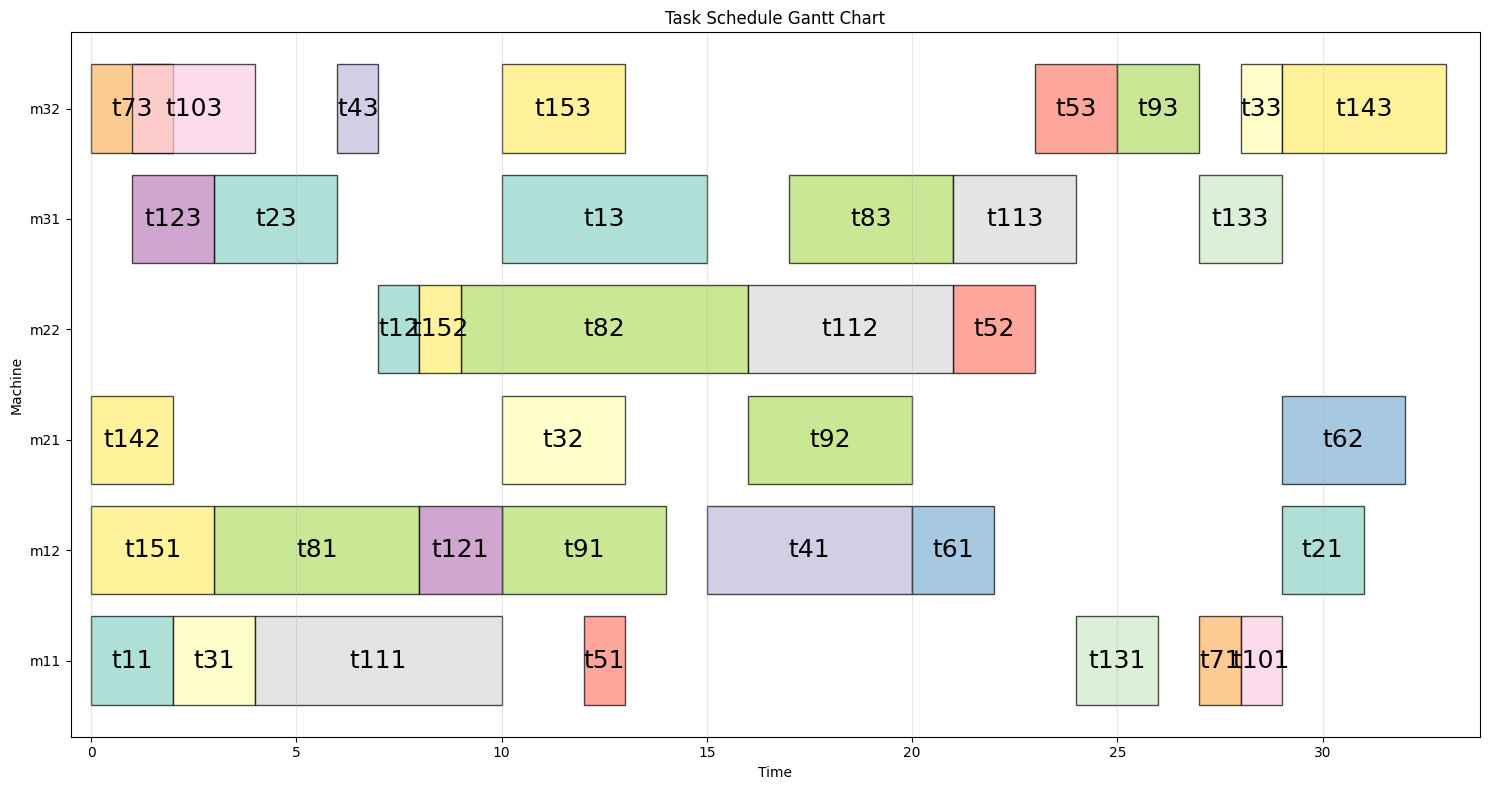

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import math

def create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time, job):
    # 全てのマシンリソースを取得
    all_machines = sorted(list(machine_processing_time.keys()))
    machine_to_idx = {machine: idx for idx, machine in enumerate(all_machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = task_to_resource[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # ジョブごとに異なる色を設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(job)))  # ジョブ数に応じたカラーマップ
    job_colors = {tuple(tasks): color for tasks, color in zip(job, colors)}  # ジョブと色を対応付け
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスク名が属するジョブを見つけて色を設定
        task_color = None
        for tasks in job:
            if task in tasks:
                task_color = job_colors[tuple(tasks)]
                break
        
        if task_color is None:
            raise ValueError(f"Task {task} not found in job list")
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=task_color,
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=18)
    
    # グラフの装飾
    ax.set_yticks(range(len(all_machines)))
    ax.set_yticklabels(all_machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# タスクスケジュールの例
fig, ax = create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time, job)
plt.show()

Task t11: Processing time = 2
Task t12: Processing time = 1
Task t13: Processing time = 5
Task t21: Processing time = 2
Task t23: Processing time = 3
Task t31: Processing time = 2
Task t32: Processing time = 3
Task t33: Processing time = 1
Task t41: Processing time = 5
Task t43: Processing time = 1
Task t51: Processing time = 1
Task t52: Processing time = 2
Task t53: Processing time = 2
Task t61: Processing time = 2
Task t62: Processing time = 3
Task t71: Processing time = 1
Task t73: Processing time = 2
Task t81: Processing time = 5
Task t82: Processing time = 7
Task t83: Processing time = 4
Task t91: Processing time = 4
Task t92: Processing time = 4
Task t93: Processing time = 2
Task t101: Processing time = 1
Task t103: Processing time = 3
Task t111: Processing time = 6
Task t112: Processing time = 5
Task t113: Processing time = 3
Task t121: Processing time = 2
Task t123: Processing time = 2
Task t131: Processing time = 2
Task t133: Processing time = 2
Task t142: Processing time = 2


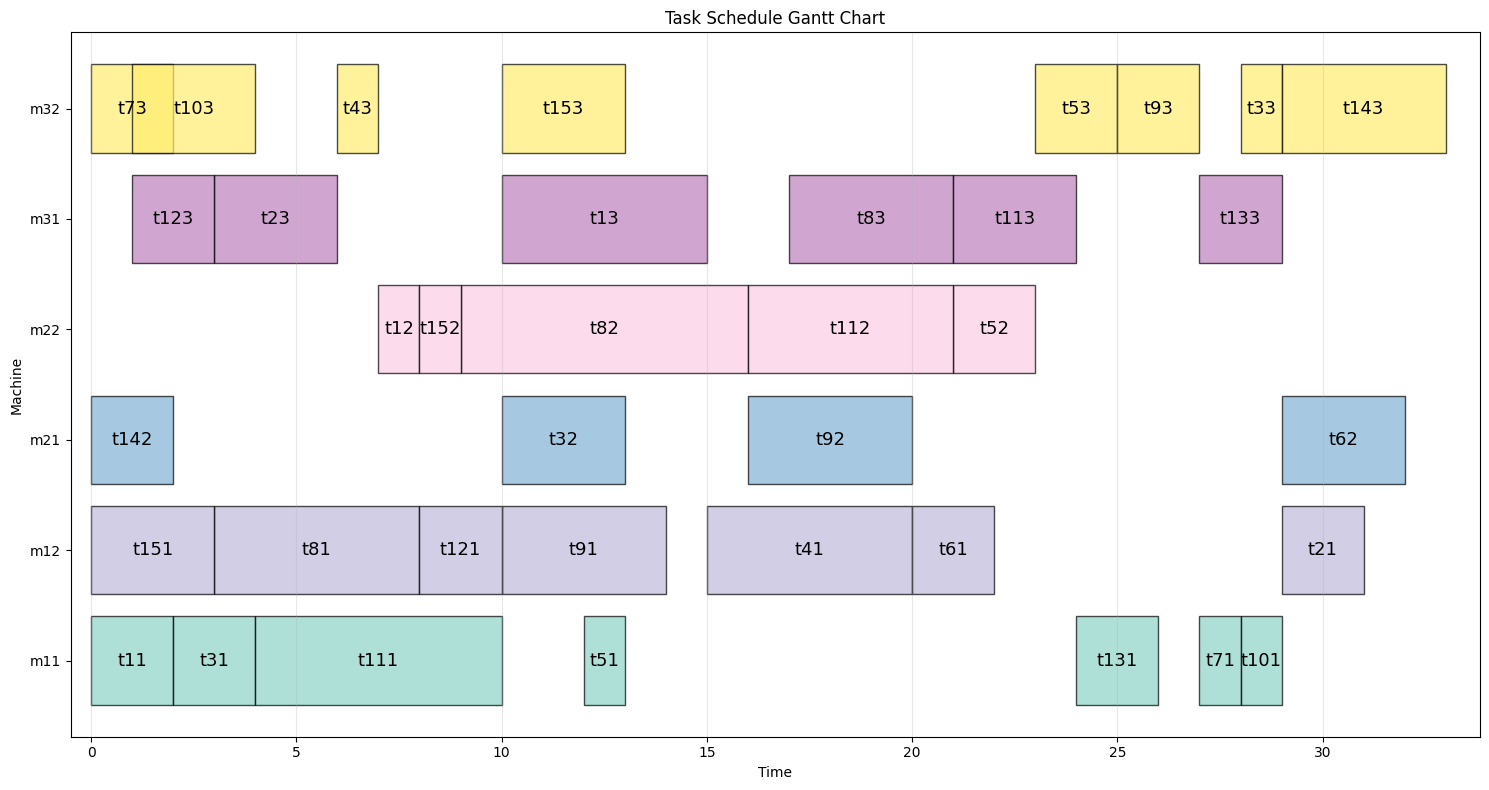

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import math

def create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time):
    # 全てのマシンリソースを取得
    all_machines = sorted(list(machine_processing_time.keys()))
    machine_to_idx = {machine: idx for idx, machine in enumerate(all_machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = task_to_resource[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_machines)))
    machine_colors = dict(zip(all_machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=13)
    
    # グラフの装飾
    ax.set_yticks(range(len(all_machines)))
    ax.set_yticklabels(all_machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# タスクスケジュールの例
fig, ax = create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time)
plt.show()

## データをcsvに保存する

In [107]:
# import csv
# import os
# from datetime import datetime

# now = datetime.now()
# timestamp = now.strftime('%Y-%m-%d')

# # 保存するファイル名
# csv_filename = f'./search/t_30/0901/{timestamp}_patt30_job{num_jobs}.csv' #任意のファイル名

# # CSVファイルが存在するかどうかを確認
# file_exists = os.path.isfile(csv_filename)

# constraint_error = best_sample.constraints(only_broken=True)
# feasible = 0 if is_feasible else constraint_error 
# #制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# # データをリストのリストとして準備
# # data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
# data = [[num_iterations, resource_cost, waiting_time, feasible]]

# # ファイルが存在しない場合はヘッダーを追加
# if not file_exists:
#     with open(csv_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
#         writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
#         writer.writerows(data)
# else:
#     # ファイルが存在する場合は追記
#     with open(csv_filename, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)

## データに対して平均と分散をplot

In [108]:
# import pandas as pd
# import numpy as np
# import re
# import glob
# import matplotlib.pyplot as plt

# # 全パターンのファイルパスを取得
# file_paths = glob.glob("../search/t_30/0901/2024-09-01_patt*_job15.csv") #任意のファイル名
# # file_paths = glob.glob("./search/t_30/2024-08-22_patt*_job15.csv")

# # 結果を保存するリスト
# all_results = []

# # 各ファイルに対して処理を適用
# for file_path in file_paths:
#     # ファイル名からパターン番号を抽出
#     patt_number = int(re.search(r'patt(\d+)', file_path).group(1))
    
#     # CSVファイルを読み込む
#     df = pd.read_csv(file_path)
    
#     # feasibleが0の行のみを選択（文字列'0'も含む）
#     df_feasible_0 = df[df['feasible'].astype(str) == '0']
    
#     # resource_cost, wating_time, feasible列を数値に変換
#     df_feasible_0['resource_cost'] = pd.to_numeric(df_feasible_0['resource_cost'], errors='coerce')
#     df_feasible_0['waiting_time'] = pd.to_numeric(df_feasible_0['waiting_time'], errors='coerce')
#     df_feasible_0['feasible'] = pd.to_numeric(df_feasible_0['feasible'], errors='coerce')
    
#     # 数値に変換できなかったデータを除外
#     df_feasible_0 = df_feasible_0.dropna(subset=['resource_cost', 'waiting_time', 'feasible'])
    
#     # iteration毎にresource_costとwating_timeの平均と分散を計算
#     summary = df_feasible_0.groupby('iteration').agg(
#         mean_resource_cost=('resource_cost', 'mean'),
#         var_resource_cost=('resource_cost', 'var'),
#         mean_waiting_time=('waiting_time', 'mean'),
#         var_waiting_time=('waiting_time', 'var'),
#     ).reset_index()
    
#     # パターン番号を追加
#     summary['patt'] = patt_number
    
#     # パターン番号とiterationを結合して新しいラベルを作成
#     summary['label'] = summary['patt'].astype(str) + "_" + summary['iteration'].astype(str)
    
#     # リストに追加
#     all_results.append(summary)
    
# # 全パターンの結果を結合
# final_df = pd.concat(all_results)

# # パターンごとに結果をソート
# final_df = final_df.sort_values(by=['patt', 'iteration'])

# final_df

In [109]:
# # resource_costをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_rc = np.sqrt(final_df['var_resource_cost'])

# plt.errorbar(final_df['label'], final_df['mean_resource_cost'], 
#              yerr=err_rc,
#              fmt='o-', color='blue', capsize=5, label='Resource Cost')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Resource Cost')
# plt.title('Average and Variance of Resource Cost by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

In [110]:
# # wating_timeをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_wt = np.sqrt(final_df['var_waiting_time'])

# plt.errorbar(final_df['label'], final_df['mean_waiting_time'], 
#              yerr=err_wt,
#              fmt='o-', color='orange', capsize=5, label='Waiting Time')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Waiting Time')
# plt.title('Average and Variance of Waiting Time by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

## パラメータDを固定しEの変えていき平均の値のデータ取得後plot

In [111]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # 読み込むCSVファイルのリスト
# csv_files = [
#     '../search/t_30/0901/final_summary_1_to_6.csv',
#     '../search/t_30/0901/final_summary_7_to_12.csv',
#     '../search/t_30/0901/final_summary_13_to_18.csv',
#     '../search/t_30/0901/final_summary_19_to_24.csv',
#     '../search/t_30/0901/final_summary_25_to_30.csv'
# ]

# # 凡例のラベルをDの値に対応させる
# legend_labels = ['D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# # カラーマップを作成（viridisカラーマップを使用）
# colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax1.plot(
#         x_indices, 
#         final_df['mean_resource_cost'], 
#         marker='o', linestyle='-', color=colors[i], 
#         label=legend_labels[i]
#     )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax2.plot(
#         x_indices, 
#         final_df['mean_waiting_time'], 
#         marker='x', linestyle='--', color=colors[i], 
#         label=legend_labels[i]
#     )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('parameter E')
# ax1.set_ylabel('resource cost')
# ax2.set_ylabel('waiting time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()

## パレートフロントのプロット

/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


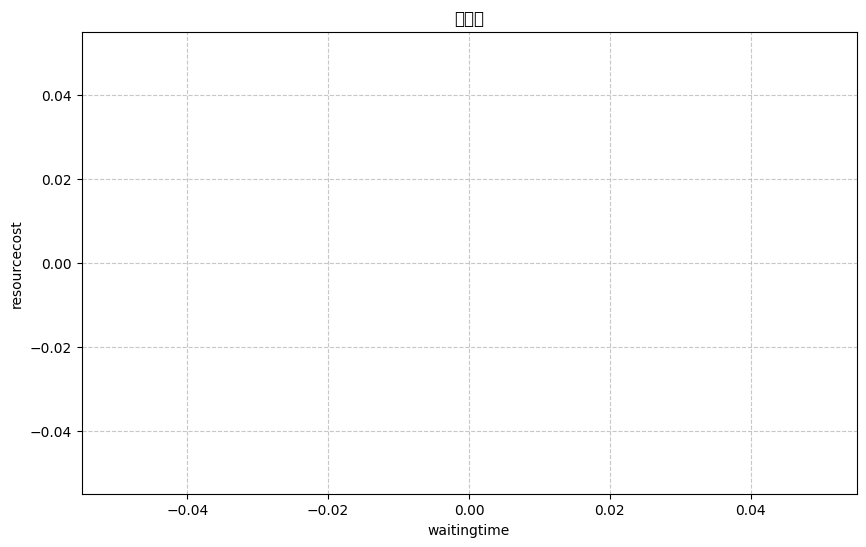

In [112]:
import seaborn as sns

# CSVファイルからデータを読み込み
optimization = pd.read_csv("optimization_results.csv")

# feasibleがTrueのデータのみをフィルタリング
feasible_data = optimization[optimization['feasible'] == True]

# プロットの作成
plt.figure(figsize=(10, 6))
sns.scatterplot(data=feasible_data, x='SubH5', y='SubH4')

plt.title('データ')
plt.xlabel('waitingtime')
plt.ylabel('resourcecost')

# グリッドの表示
plt.grid(True, linestyle='--', alpha=0.7)

# プロットの表示
plt.show()

In [113]:
# import optuna.visualization.matplotlib as mpl

# # CSVファイルからデータを読み込む
# df = pd.read_csv("optimization_results.csv")

# # feasibleなデータのみを抽出
# feasible_data = df[df['feasible'] == True]

# # OptunaのStudyオブジェクトを模倣するためのクラス
# class Trial:
#     def __init__(self, number, values):
#         self.number = number
#         self.values = values

# class FakeStudy:
#     def __init__(self, trials, directions):
#         self.trials = trials
#         self.directions = directions

# # データを変換
# trials = []
# for i, row in feasible_data.iterrows():
#     values = [row['SubH4'], row['SubH5']]
#     trial = Trial(i, values)
#     trials.append(trial)

# # Studyオブジェクトを作成（両方の目的関数を最小化）
# study = FakeStudy(trials, ["minimize", "minimize"])

# # パレートフロントのプロット
# fig = mpl.plot_pareto_front(study, target_names=["SubH4", "SubH5"])

# # プロットの体裁を調整
# plt.title("Pareto Front of Feasible Solutions")
# plt.xlabel("ResourceCost")
# plt.ylabel("WaitingTime")
# plt.grid(True, linestyle='--', alpha=0.7)

# # プロットを表示
# plt.show()

# # パレート最適解の特定と表示
# pareto_trials = []
# pareto_values = []
# for trial in trials:
#     is_pareto = True
#     for other_trial in trials:
#         if (trial.values[0] > other_trial.values[0] and 
#             trial.values[1] >= other_trial.values[1]) or (
#             trial.values[0] >= other_trial.values[0] and 
#             trial.values[1] > other_trial.values[1]):
#             is_pareto = False
#             break
#     if is_pareto:
#         pareto_trials.append(trial)
#         pareto_values.append(trial.values)

# print("\nPareto optimal solutions:")
# print("SubH4\tSubH5")
# for values in sorted(pareto_values):
#     print(f"{values[0]:.2f}\t{values[1]:.2f}")

# # 統計情報の表示
# print(f"\nTotal number of feasible solutions: {len(trials)}")
# print(f"Number of Pareto optimal solutions: {len(pareto_values)}")